In [10]:
import time,os
from subprocess import call
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/")
def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
    codeDir = "/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/recognitionDataAnalysis/"
    call(f'squeue -u kp578 | wc -l > {codeDir}squeue{randomID}.txt',shell=True)
    numberOfJobsRunning = int(open(f"{codeDir}squeue{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning

numOfRunningJobs()

numberOfJobsRunning=4


4

In [ ]:
for i in range(int(1e100)):
    n=numOfRunningJobs()
    if n<=2:
        break
    else:
        time.sleep(10)
call("sbatch SUMA_Make_Spec_FS.sh sub002",shell=True)
call("sbatch SUMA_Make_Spec_FS.sh sub102",shell=True)

numberOfJobsRunning=4
numberOfJobsRunning=4
numberOfJobsRunning=4


In [16]:
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt/expScripts/recognition


In [20]:
#  this script is meant to deal with the data of 8 recognition runs and generate models saved in corresponding folder
'''
input:
    cfg.session=ses1
    cfg.modelFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/clf/"
    cfg.dataFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/"
output:
    models in cfg.modelFolder
'''


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from scipy.stats import zscore
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
import pickle5 as pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


argParser = argparse.ArgumentParser()
argParser.add_argument('--config', '-c', default='sub002.ses1.toml', type=str, help='experiment file (.json or .toml)')
argParser.add_argument('--skipPre', '-s', default=0, type=int, help='skip preprocess or not')
argParser.add_argument('--skipGreedy', '-g', default=0, type=int, help='skip greedy or not')
args = argParser.parse_args("")
from rtCommon.cfg_loading import mkdir,cfg_loading
# config="sub001.ses2.toml"
cfg = cfg_loading(args.config)
cfg

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub002.ses1.toml


{'title': 'rtSynth_rt',
 'session': 1,
 'subjectDay': 1,
 'runNum': [1],
 'scanNum': [1],
 'subjectName': 'sub002',
 'LASTNAME': 'rtSynth_sub002',
 'subjectIDforxnat': 'rtSynth_sub002_ses1',
 'realtimeFolder_subjectName': 'rtSynth_sub002',
 'preDay_YYYYMMDD': '0',
 'YYYYMMDD': '20210510',
 'num_total_TRs': 174,
 'TrialNumber': 12,
 'plotTitle': 'Realtime Plot',
 'plotXLabel': 'Sample #',
 'plotYLabel': 'B prob',
 'plotXRangeLow': 0,
 'plotXRangeHigh': 176,
 'plotYRangeLow': 0,
 'plotYRangeHigh': 20,
 'plotAutoRangeX': False,
 'plotAutoRangeY': True,
 'minExpectedDicomSize': 300000,
 'projectDir': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/',
 'tmp_folder': '/tmp/',
 'orderFolder': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/orders/',
 'subjects_dir': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/',
 'dicom_folder': '/gpfs/milgram/project/realtime/DICOM/',
 'recognition_expScripts_dir': '/gpfs/milgram/project/turk-browne/pr

In [24]:
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading,greedyMask,normalize #,classifierEvidence
curr_run_behav=1
behav_data = behaviorDataLoading(cfg,curr_run_behav+1)


IndexError: single positional indexer is out-of-bounds

In [26]:

# import and set up environment
import sys
from subprocess import call
import nibabel as nib
import pydicom as dicom
import numpy as np
import time
import os
from glob import glob
import shutil
import pandas as pd
# from import convertDicomFileToNifti
from rtCommon.imageHandling import convertDicomImgToNifti, readDicomFromFile
from rtCommon.cfg_loading import mkdir,cfg_loading


# def behaviorDataLoading(cfg,curr_run):
cfg,curr_run=cfg,1
'''
extract the labels which is selected by the subject and coresponding TR and time
check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
'''
behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{curr_run}.csv")

# the item(imcode) colume of the data represent each image in the following correspondence
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}

# When the imcode code is "A", the correct response should be '1', "B" should be '2'
correctResponseDict={
'A': 1,
'B': 2,
'C': 1,
'D': 2}

# extract the labels which is selected by the subject and coresponding TR and time
behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item']] # the TR, the real time it was presented, 

# 为了处理 情况 A.被试的反应慢了一个TR，或者 B.两个按钮都被按了(这种情况下按照第二个按钮处理)
# 现在的问题是”下一个TR“可能超过了behav_data的长度
# this for loop is to deal with the situation where Resp is late for 1 TR, or two buttons are pressed. 
# when Resp is late for 1 TR, set the current Resp as the later Response.
# when two buttons are pressed, set the current Resp as the later Response because the later one should be the real choice
for curr_trial in range(behav_data.shape[0]):
    if behav_data['Item'].iloc[curr_trial]  in ["A","B","C","D"]:
        if curr_trial+1<behav_data.shape[0]: # 为了防止”下一个TR“超过behav_data的长度  中文
            if behav_data['Resp'].iloc[curr_trial+1] in [1.0,2.0]:
                behav_data['Resp'].iloc[curr_trial]=behav_data['Resp'].iloc[curr_trial+1]

behav_data=behav_data.dropna(subset=['Item'])

# check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
isCorrect=[]
for curr_trial in range(behav_data.shape[0]):
    isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")

behav_data['isCorrect']=isCorrect # merge the isCorrect clumne with the data dataframe
behav_data['subj']=[cfg.subjectName for i in range(len(behav_data))]
behav_data['run_num']=[int(curr_run) for i in range(len(behav_data))]
behav_data=behav_data[behav_data['isCorrect']] # discard the trials where the subject made wrong selection
# return behav_data



IndexError: single positional indexer is out-of-bounds

In [31]:
curr_trial<behav_data.shape[0]

True

In [29]:
behav_data['Resp'].iloc[curr_trial] in [1.0,2.0]
# curr_trial

True

In [32]:
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])])
actualRuns

[1, 2, 3, 4, 5, 6, 7, 8]

In [33]:
os.path.exists(f"{cfg.recognition_dir}run{actualRuns[-1]}.nii") or os.path.exists(f"{cfg.recognition_dir}run{actualRuns[-1]}.nii.gz")

True

In [34]:
f"{cfg.recognition_dir}run{actualRuns[-1]}.nii"

'/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/ses1/recognition/run8.nii'

bestID=18; best Acc = 0.4831006205673759


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


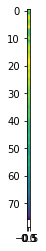

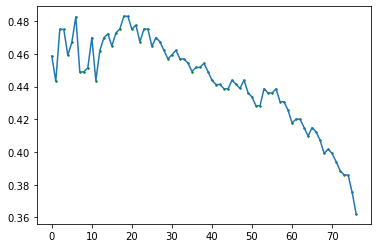

In [53]:
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt")
import matplotlib.pyplot as plt
# when every mask has run, find the best mask and save as the chosenMask
roiloc="schaefer2018"
dataSource="realtime"
subjects=[cfg.subjectName]
N=78
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    for len_topN_1 in range(N-1,0,-1):
        try:
            # print(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"{cfg.projectDir}tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T

plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))

performance_mean = np.nanmean(GreedyBestAcc,axis=1)
bestID=np.where(performance_mean==np.nanmax(performance_mean))[0][0]
di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID+1}")
print(f"bestID={bestID}; best Acc = {di['bestAcc']}")


In [65]:
for ROI in di['bestROIs']:
    print(ROI.split(".")[0],end=' ')

    
#     bash
cd /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/ses1/recognition/mask/
cp schaefer_19.nii.gz megaROI.nii.gz
for ROI in 19 195 114 163 76 258 89 249 126 93 67 10 2 238 204 150 87 22 193; do
    echo $ROI
    fslmaths schaefer_${ROI}.nii.gz -add megaROI.nii.gz megaROI.nii.gz
done
fslview_deprecated megaROI.nii.gz

# for ROI in {1..300}; do  
#     temp=${mask_dir}/tmp.nii.gz
#     OUTPUT=${mask_dir}/schaefer_${ROI}.nii.gz
#     fslmaths ${OUTPUT} -add ${temp} ${temp}
# done

19 195 114 163 76 258 89 249 126 93 67 10 2 238 204 150 87 22 193 

In [55]:
def load(path):
    brain_data = nib.load(path).get_data()
    return brain_data
T2=load("subjects/sub102/ses1/anat/gm_func.nii.gz")
T1=load("subjects/sub002/ses1/anat/gm_func.nii.gz")
np.sum(T2-T1)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


0.0

In [60]:
a={}
a[1]=1
a[2]=2
np.mean(list(a.values()))

1.5

In [1]:
import pandas as pd
pd.read_csv("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/adaptiveThreshold.csv")

,sub,session,run,threshold,successful_trials,perfect_trials,monetaryReward1,monetaryReward5,monetaryReward9,monetaryReward13
0,sub002,2,1,0.60,12.0,6.0,NaN,NaN,NaN,NaN
1,sub002,2,2,0.60,12.0,8.0,NaN,NaN,NaN,NaN
2,sub002,2,3,0.60,12.0,3.0,NaN,NaN,NaN,NaN
3,sub002,2,4,0.60,10.0,3.0,NaN,NaN,NaN,NaN
4,sub002,2,5,0.60,11.0,8.0,NaN,NaN,NaN,NaN
5,sub002,2,6,0.60,12.0,6.0,NaN,NaN,NaN,NaN
6,sub002,2,7,0.65,8.0,3.0,1080.0,721.0,720.0,1440.0
7,sub002,2,8,0.65,6.0,1.0,360.0,360.0,1081.0,2160.0
8,sub002,2,9,0.65,11.0,3.0,721.0,1080.0,1800.0,360.0
9,sub002,2,10,0.70,10.0,5.0,1799.0,360.0,1440.0,361.0
